In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, os
import pandas as pd, numpy as np, seaborn as sn, imp
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
sn.set_context('notebook')

# ECCO-DomQua data processing

In a [previous notebook]() I developed and tested code for spatially interpolating the ECCO-DomQua data over Fenoscandia. The key classes and functions used in that notebook have been moved into a new file called `spatial_interpolation.py`, which means I can now import and use them in other notebooks without have to re-enter all the code. This should help to keep subsequent notebooks tidy.

In this notebook I'm going to use my spatial interpolation code to generate grids for ECCO-DomQua. Accroding to the file here:

K:\Prosjekter\Klima\O-13382 DomQua HWI\8 Future DOC\Gridded_Data_Tasks.docx

Leah would like gridded versions of the EMEP data for 1995, 2010, 2020 and 2030. She would also like 1995 water chemistry grids for the following variables: TOC, Cl, nmCaMg, SO4 and nmSO4.

## 1. Import functions

The functions and classes created in the [previous notebook]() are imported below.

In [2]:
# Import custom functions and connect to db
spat_int_path = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Python\spatial_interpolation.py'

spat_int = imp.load_source('spatial_interpolation', spat_int_path)

## 2. Read raw data

### 2.1. EMEP

In [3]:
# Read EMEP
emep_xlsx = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\S_LoLa_a_tidy.xlsx')
emep_df = pd.read_excel(emep_xlsx, sheetname='Sheet1')

emep_df.head()

,Lon,Lat,1880,1885,1890,1895,1900,1905,1910,1915,...,1975,1980,1985,1990,1995,2000,2005,2010,2020,2030
0,7.5,54.0,557.0,630.3,735.3,791.5,960.1,1044.2,1217.7,1264.0,...,3469.8,3554.3,2832.7,2353.4,1172.4,767.1,629.3,481.1,237.9,200.9
1,8.5,54.0,537.2,619.0,729.4,791.2,973.0,1068.6,1263.2,1313.2,...,3960.8,4115.2,3179.9,2664.0,1226.6,791.2,643.4,492.8,261.4,220.4
2,9.0,54.0,504.2,586.3,695.6,761.0,943.1,1044.2,1242.0,1304.7,...,4264.2,4437.3,3443.9,3056.1,1271.8,805.6,654.7,510.8,284.8,241.9
3,9.5,54.0,482.0,566.0,676.7,746.7,932.7,1040.8,1245.7,1320.6,...,4612.2,4806.9,3868.9,3905.3,1426.0,884.0,720.0,581.6,344.9,293.0
4,10.0,54.0,482.0,567.8,680.8,753.4,943.5,1055.4,1266.2,1345.3,...,4802.9,5013.2,4366.7,3186.4,1191.0,736.0,600.0,486.4,287.2,245.6


### 2.2. Water chemistry

In [4]:
# Read chemistry
chem_xlsx = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Water_Chem\Nordic_data_GIS_Import.xlsx')
chem_df = pd.read_excel(chem_xlsx, sheetname='Nordic95_LakeChem_SiteProprties')

chem_df.head()

,Station_ID,Lat,Long,Country,TOC,Cl,nmCaMg,SO4,nmSO4
0,9,59.00,11.56,Norway,10.0,174.87,66.76,99.93,81.92
1,10,59.80,11.85,Norway,11.7,53.59,81.82,62.45,56.94
2,11,60.05,12.44,Norway,12.1,42.30,105.92,62.45,58.10
3,12,60.32,11.84,Norway,8.0,28.20,43.08,56.21,53.30
4,13,60.59,12.51,Norway,9.3,22.56,83.41,54.13,51.80


## 3. Map projection

Setup the map projection and define the grid for interpolation.

In [5]:
# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63, # Central point
            ellps='WGS84')     # http://matplotlib.org/basemap/api/basemap_api.html

# Set up 25 km grid for interpolation
gridx = np.arange(int(m.xmin), int(m.xmax), 25000)
gridy = np.arange(int(m.ymin), int(m.ymax), 25000)

## 4. Interpolation

### 4.1. EMEP

In [6]:
# Output folder
out_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Output_GTiffs'

# Map (long, lat) to projected (x, y)
x, y = m(emep_df['Lon'].values, emep_df['Lat'].values)

# Reformat to synatx required by interp algorithms
pts = np.array(zip(x ,y))

# Loop over years
for year in [1995, 2010, 2020, 2030]:    
    # Get values to interpolate
    vals = emep_df[year].values

    # IDW interpolation
    idw = spat_int.idw_interp(pts, vals, 
                              gridx, gridy, 
                              n_near=8, p=2)

    # Spline interpolation
    xx, yy = np.meshgrid(gridx, gridy) 
    spl = griddata(pts, vals, 
                   (xx, yy), 
                   method='cubic')

    # Save output
    # IDW
    idw_path = os.path.join(out_fold, 'emep_%s_idw_n8_p2.tif' % year)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            idw_path, idw, m.proj4string)
    
    # Spline
    spl_path = os.path.join(out_fold, 'emep_%s_spline.tif' % year)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            spl_path, spl, m.proj4string)

### 4.2. Water chemistry

In [7]:
# Output folder
out_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Water_Chem\Output_GTiffs'

# Map (long, lat) to projected (x, y)
x, y = m(chem_df['Long'].values, chem_df['Lat'].values)

# Reformat to synatx required by interp algorithms
pts = np.array(zip(x ,y))

# Loop over years
for par in ['TOC', 'Cl', 'nmCaMg', 'SO4', 'nmSO4']:    
    # Get values to interpolate
    vals = chem_df[par].values

    # IDW interpolation
    idw = spat_int.idw_interp(pts, vals, 
                              gridx, gridy, 
                              n_near=8, p=2)

    # Spline interpolation
    xx, yy = np.meshgrid(gridx, gridy) 
    spl = griddata(pts, vals, 
                   (xx, yy), 
                   method='cubic')

    # Save output
    # IDW
    idw_path = os.path.join(out_fold, 'chem_%s_idw_n8_p2.tif' % par)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            idw_path, idw, m.proj4string)
    
    # Spline
    spl_path = os.path.join(out_fold, 'chem_%s_spline.tif' % par)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            spl_path, spl, m.proj4string)

## 5. Visualisation

### 5.1. EMEP

The visualisation below plots the EMEP output (note that each plot uses it's own scale).

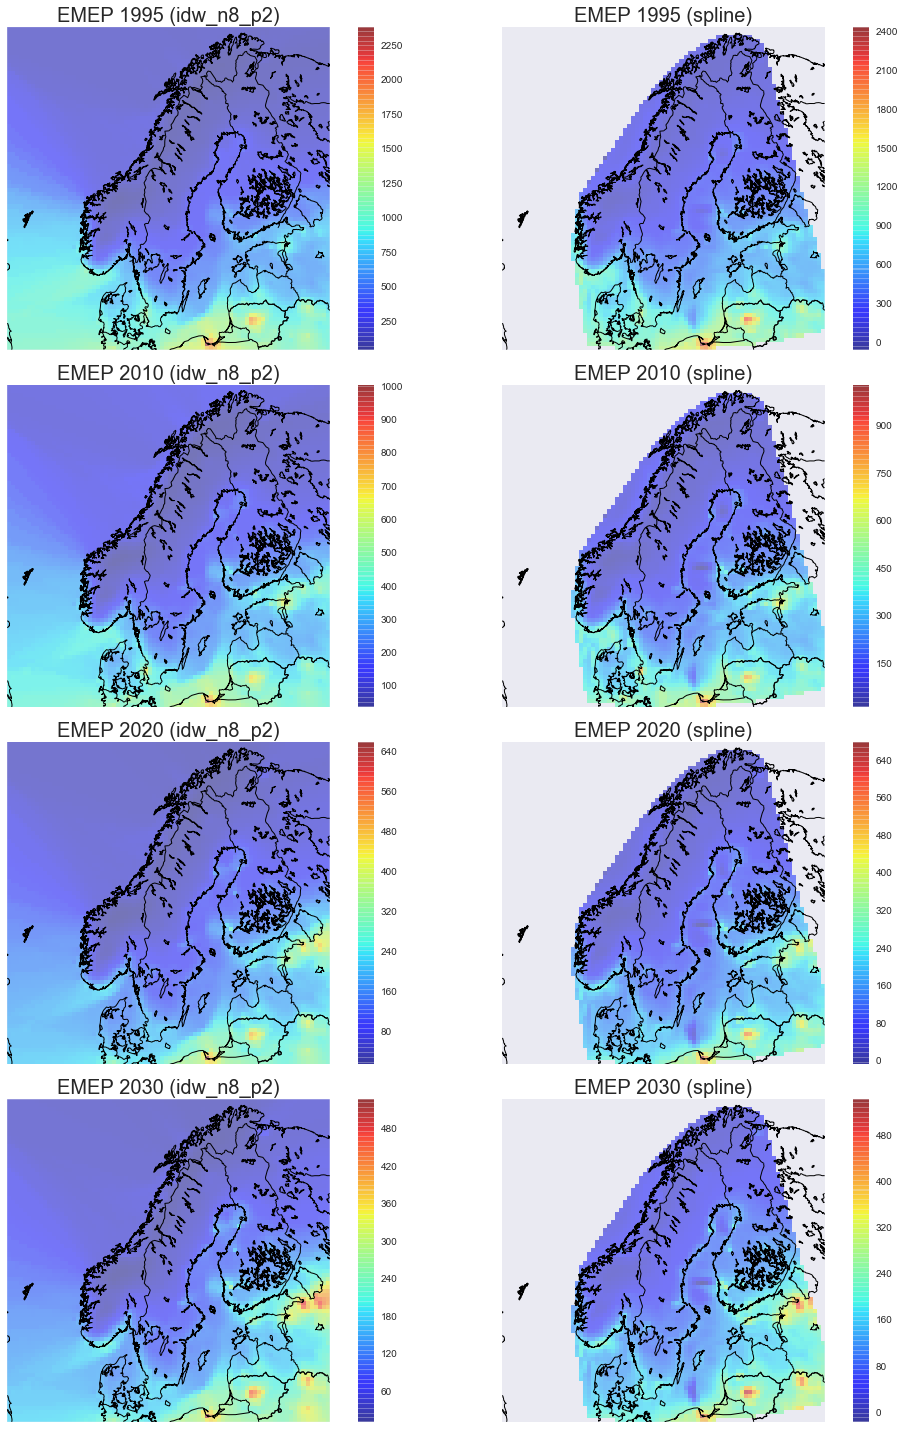

In [15]:
# Data folder
data_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Output_GTiffs'

fig = plt.figure(figsize=(15, 20))
cnt = 0

for year in [1995, 2010, 2020, 2030]:
    for meth in ['idw_n8_p2', 'spline']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(data_fold, 'emep_%s_%s.tif' % (year, meth))
        data = spat_int.read_geotiff(gtiff_path)[0]
        
        # Plot
        ax = fig.add_subplot(4, 2, cnt)
        ax.set_title('EMEP %s (%s)' % (year, meth), fontsize=20)
        cax = m.imshow(data, 
                       cmap='jet', alpha=0.5, 
                       interpolation='none')
        m.drawcoastlines(linewidth=1)
        m.drawcountries(linewidth=1)
        cbar = fig.colorbar(cax)

plt.tight_layout()

We can force all the plots to use the same colour scheme by using the `vmin` and `vmax` arguments (although then the deposition for more recent years is so low that variations are difficult to distinguish).

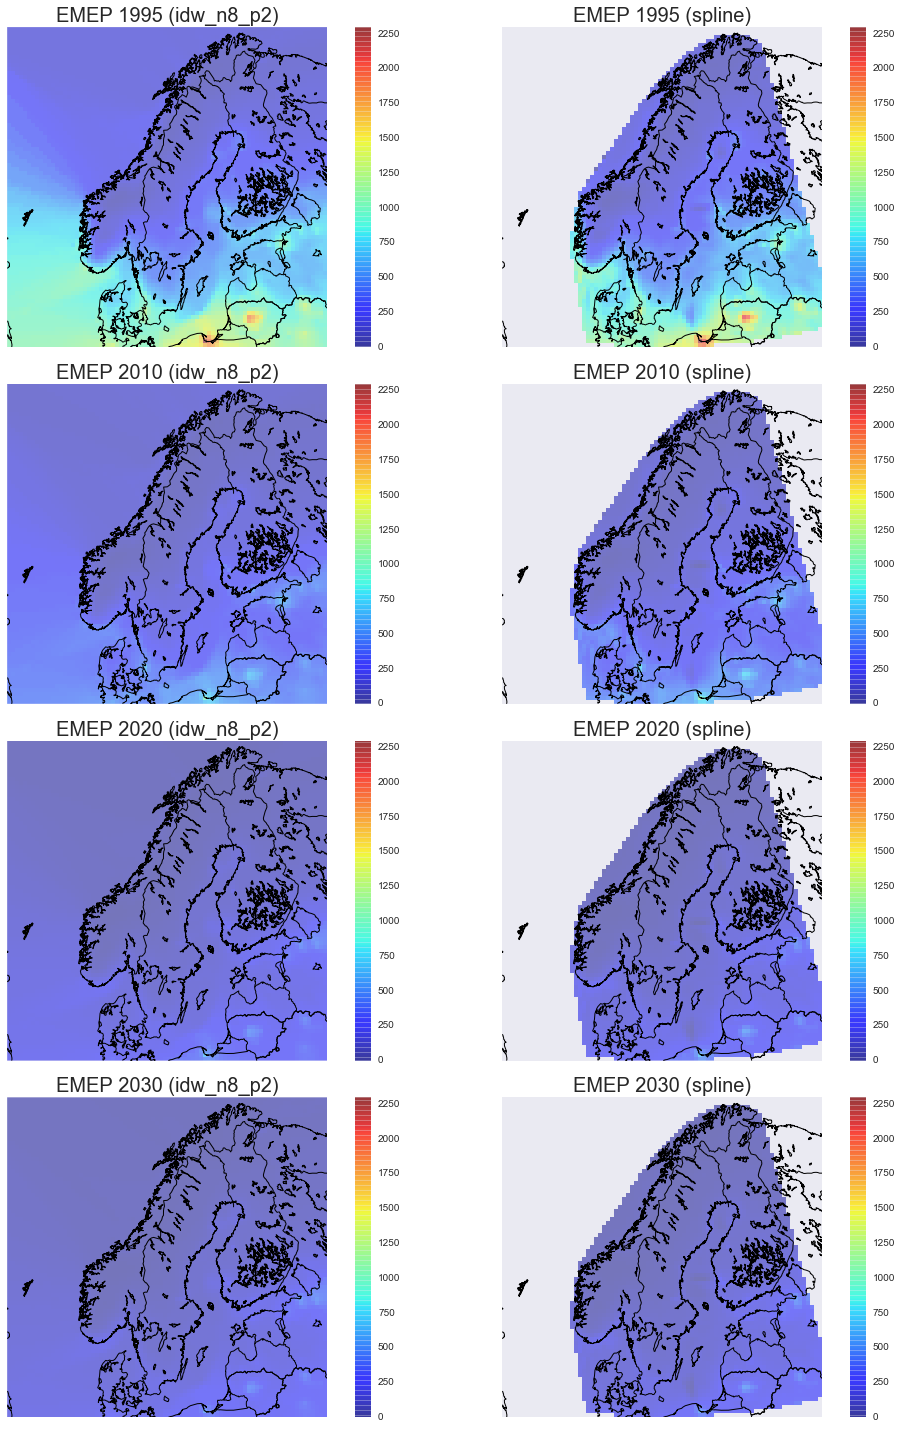

In [16]:
# Data folder
data_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Output_GTiffs'

fig = plt.figure(figsize=(15, 20))
cnt = 0

for year in [1995, 2010, 2020, 2030]:
    for meth in ['idw_n8_p2', 'spline']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(data_fold, 'emep_%s_%s.tif' % (year, meth))
        data = spat_int.read_geotiff(gtiff_path)[0]
        
        # Plot
        ax = fig.add_subplot(4, 2, cnt)
        ax.set_title('EMEP %s (%s)' % (year, meth), fontsize=20)
        cax = m.imshow(data, 
                       cmap='jet', alpha=0.5, 
                       interpolation='none',
                       vmin=0, vmax=2300)
        m.drawcoastlines(linewidth=1)
        m.drawcountries(linewidth=1)
        cbar = fig.colorbar(cax)

plt.tight_layout()

### 5.2. Water chemistry

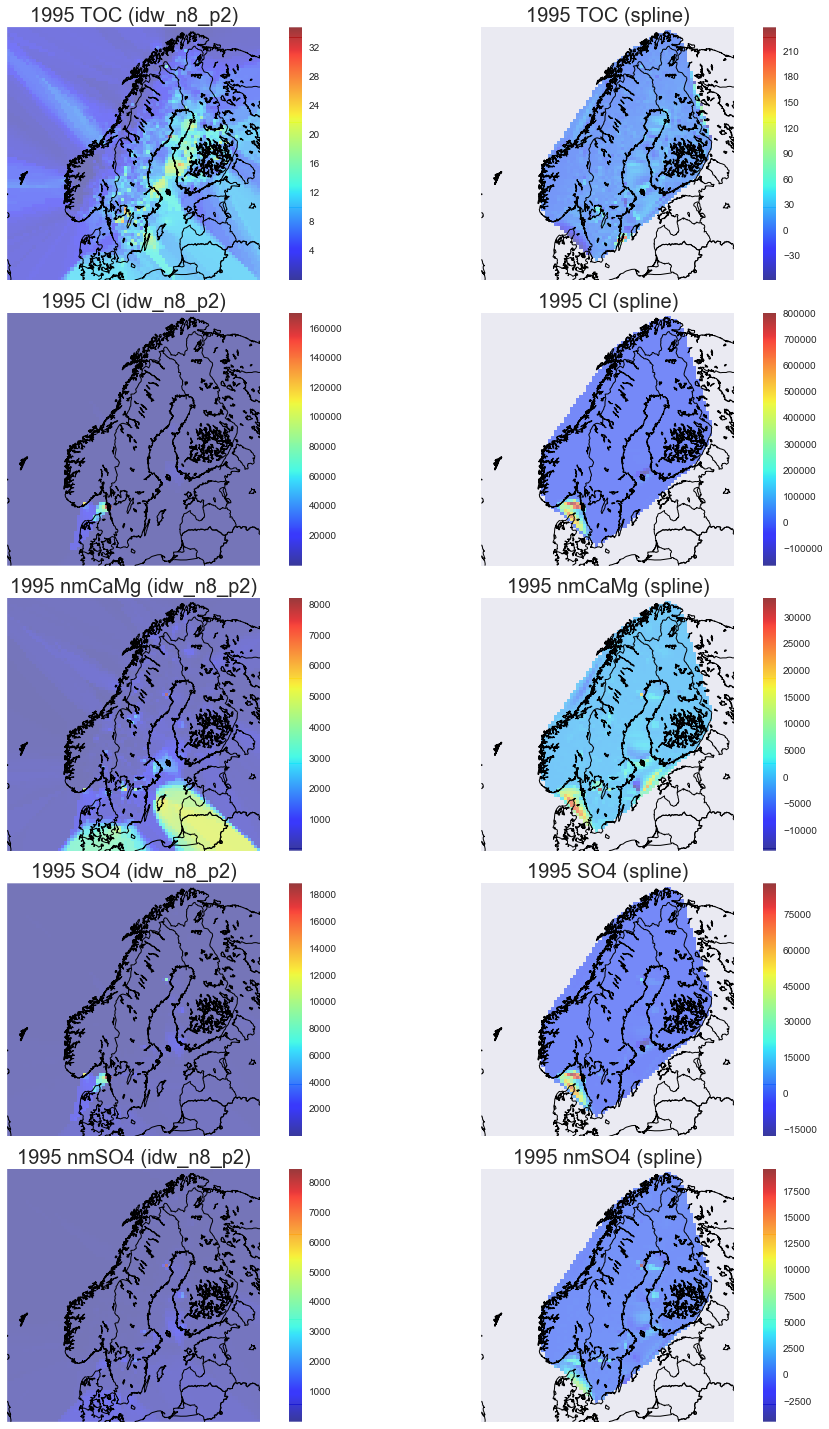

In [18]:
# Data folder
data_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Water_Chem\Output_GTiffs'

fig = plt.figure(figsize=(15, 20))
cnt = 0

for par in ['TOC', 'Cl', 'nmCaMg', 'SO4', 'nmSO4']:
    for meth in ['idw_n8_p2', 'spline']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(data_fold, 'chem_%s_%s.tif' % (par, meth))
        data = spat_int.read_geotiff(gtiff_path)[0]
        
        # Plot
        ax = fig.add_subplot(5, 2, cnt)
        ax.set_title('1995 %s (%s)' % (par, meth), fontsize=20)
        cax = m.imshow(data, 
                       cmap='jet', alpha=0.5, 
                       interpolation='none')
        m.drawcoastlines(linewidth=1)
        m.drawcountries(linewidth=1)
        cbar = fig.colorbar(cax)

plt.tight_layout()

The water chemistry data is clearly more difficult to interpolate. In particular, the output from the splies algorithm seems rather extreme, and often involve large negative values. This is due to large outliers in the raw forcing very tight bend in the spline surface, which sometimes 'dip' down and become negative. Overall, I'd be inclined to use the IDW output here, as the values are always calculated as an average of actual measurements, with reduces some of the weird effects associated with the "rubber-sheeting" behaviour of the splines algorithm. However, I think it would also be worth **checking the raw data carefully for outliers**, or perhaps log-transforming the data prior to interpolation?